# Research Dataset Preparation
This notebook prepares a research dataset to analyze the relationship between audio features and song success over different eras.

In [628]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [629]:
df = pd.read_csv('data/song_hits_and_audio_features.csv')
df.isnull().sum()

Track               0
Artist              0
Year                0
Duration            0
Time_Signature      0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
Popularity          0
Genre               0
dtype: int64

## Data Cleaning and Feature Engineering
<li> renaming columns to lowercase
<li> changing duration from milliseconds to minutes
<li> creating scaled cols (standardise) to later feature engineer
<li> creating new cols of features that are highly correlated

In [630]:
df = df.rename(columns={"Track": "name"})
df.columns = df.columns.str.lower()
# changing duration from milliseconds to minutes
df["duration"] = (df["duration"] / 60000).round(2)
from sklearn.preprocessing import StandardScaler

# 1 creating scaled cols (standardise) to later feature engineer
scaler = StandardScaler()

df['loudness_scaled'] = scaler.fit_transform(df[['loudness']])
df['energy_scaled'] = scaler.fit_transform(df[['energy']])
df['acousticness_scaled'] = scaler.fit_transform(df[['acousticness']])
df['danceability_scaled'] = scaler.fit_transform(df[['danceability']])
df['valence_scaled'] = scaler.fit_transform(df[['valence']])
df["era"] = pd.cut(df["year"], bins=[1889, 1969, 1979, 1989, 1999, 2009, 2029],
                   labels=["<=60s", "70s", "80s", "90s", "00s", ">=10s"])

# 2. creating new cols of features that are highly correlated
# 'intensity' and 'feel_good_factor' combine complementary features, so mean is appropriate.
df['intensity'] = df[['energy_scaled', 'loudness_scaled']].mean(axis=1)
df['feel_good_factor'] = df[['danceability_scaled', 'valence_scaled']].mean(axis=1)

# For 'production_balance', we use the difference to capture the trade-off between electronic and acoustic sounds.
df['production_balance'] = df['energy_scaled'] - df['acousticness_scaled']
df.head(20)

,name,artist,year,duration,time_signature,danceability,energy,key,loudness,mode,...,genre,loudness_scaled,energy_scaled,acousticness_scaled,danceability_scaled,valence_scaled,era,intensity,feel_good_factor,production_balance
0,Hey Jack Kerouac,"10,000 Maniacs",1987,3.44,4,0.616,0.5110,6,-15.894,1,...,Alt. Rock,-1.571182,-0.445439,-0.831545,0.248692,0.130913,80s,-1.008311,0.189802,0.386105
1,Like the Weather,"10,000 Maniacs",1987,3.94,4,0.770,0.4590,1,-17.453,1,...,Alt. Rock,-1.934635,-0.662541,-0.599940,1.175270,1.561414,80s,-1.298588,1.368342,-0.062601
2,What's the Matter Here?,"10,000 Maniacs",1987,4.85,4,0.593,0.8160,9,-7.293,1,...,Alt. Rock,0.433986,0.827945,-0.938253,0.110307,-0.207785,80s,0.630965,-0.048739,1.766197
3,Trouble Me,"10,000 Maniacs",1989,3.23,4,0.861,0.3850,2,-10.057,1,...,Alt. Rock,-0.210391,-0.971493,-0.467774,1.722793,-0.307402,80s,-0.590942,0.707695,-0.503719
4,Candy Everybody Wants,"10,000 Maniacs",1992,3.10,4,0.622,0.8760,10,-6.310,1,...,Alt. Rock,0.663154,1.078446,-0.891649,0.284792,1.178885,90s,0.870800,0.731838,1.970095
5,More Than This,"10,000 Maniacs",1992,4.09,4,0.623,0.7730,6,-8.800,1,...,Alt. Rock,0.082656,0.648418,-0.903606,0.290809,0.939804,90s,0.365537,0.615306,1.552025
6,These Are Days,"10,000 Maniacs",1992,3.66,4,0.611,0.8330,3,-7.554,1,...,Alt. Rock,0.373138,0.898920,-0.883782,0.218608,0.884018,90s,0.636029,0.551313,1.782702
7,Verdi Cries,"10,000 Maniacs",1992,4.34,4,0.367,0.0256,3,-25.309,1,...,Alt. Rock,-3.766120,-2.471998,1.933237,-1.249477,-1.566562,90s,-3.119059,-1.408020,-4.405235
8,Because the Night - Live Unplugged,"10,000 Maniacs",1993,3.72,4,0.408,0.7900,11,-8.138,0,...,Alt. Rock,0.236989,0.719394,-0.134213,-1.002790,-0.893151,90s,0.478191,-0.947971,0.853607
9,Be Like That,3 Doors Down,2000,4.43,4,0.487,0.7020,7,-6.043,1,...,Alt. Rock,0.725401,0.351991,-0.935767,-0.527468,-1.056523,00s,0.538696,-0.791995,1.287758


### Filter for songs from the past 20 years and create a binary success column

In [631]:
songs_past_20_years = df[df['era'].isin(['00s', '>=10s'])].copy()
print(f"\nTotal songs from the past 20 years: {len(songs_past_20_years)}")
print("Popularity statistics for songs from the past 20 years:")
print(songs_past_20_years['popularity'].describe(percentiles=[.7, .75, .8, .85, .9]))


Total songs from the past 20 years: 3421
Popularity statistics for songs from the past 20 years:
count    3421.000000
mean       50.317159
std        20.117759
min         0.000000
50%        52.000000
70%        63.000000
75%        66.000000
80%        69.000000
85%        72.000000
90%        76.000000
max        98.000000
Name: popularity, dtype: float64


In [632]:
# python
import unicodedata
import re
import pandas as pd


def normalize_text(s):
    if pd.isna(s):
        return s
    s = str(s)
    # decompose unicode and remove diacritics (Beyoncé -> Beyonce)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    # lowercase, collapse whitespace, strip
    s = re.sub(r"\s+", " ", s).strip().lower()
    return s


# create normalized columns
songs_past_20_years["artist_norm"] = songs_past_20_years["artist"].apply(normalize_text)
songs_past_20_years["name_norm"] = songs_past_20_years["name"].apply(normalize_text)

# inspect how many duplicate groups (same normalized name + artist)
dup_mask = songs_past_20_years.duplicated(subset=["name_norm", "artist_norm"], keep=False)
print(f"Total duplicate rows (same name & artist after normalization): {dup_mask.sum()}")

# optional: view a sample of duplicates for manual inspection
dup_sample = songs_past_20_years[dup_mask].sort_values(["artist_norm", "name_norm"])
display(dup_sample[["name", "artist", "year", "popularity", "name_norm", "artist_norm"]].head(10))

# --- keep the highest-popularity record per duplicated group ---
songs_past_20_years = (
    songs_past_20_years.sort_values("popularity", ascending=False)
    .drop_duplicates(subset=["name_norm", "artist_norm"], keep="first")
    .reset_index(drop=True)
)

# cleanup normalized helper columns if no longer needed
songs_past_20_years = songs_past_20_years.drop(columns=["artist_norm", "name_norm"])

Total duplicate rows (same name & artist after normalization): 104


,name,artist,year,popularity,name_norm,artist_norm
11097,Crazy In Love (feat. Jay-Z),Beyonce,2003,79,crazy in love (feat. jay-z),beyonce
14233,Crazy In Love (feat. Jay-Z),Beyoncé,2003,79,crazy in love (feat. jay-z),beyonce
11104,Drunk in Love (feat. Jay-Z),Beyonce,2013,71,drunk in love (feat. jay-z),beyonce
14240,Drunk in Love (feat. Jay-Z),Beyoncé,2013,71,drunk in love (feat. jay-z),beyonce
11106,Formation,Beyonce,2016,68,formation,beyonce
14242,Formation,Beyoncé,2016,68,formation,beyonce
11099,Halo,Beyonce,2008,72,halo,beyonce
14235,Halo,Beyoncé,2008,72,halo,beyonce
11100,If I Were a Boy,Beyonce,2008,64,if i were a boy,beyonce
14236,If I Were a Boy,Beyoncé,2008,64,if i were a boy,beyonce


In [633]:
print(f"\nAfter removing duplicates, total songs from the past 20 years: {len(songs_past_20_years)}")
print(f"checking it worked - should be 0: {songs_past_20_years.duplicated(subset=['name', 'artist']).sum()}")


After removing duplicates, total songs from the past 20 years: 3369
checking it worked - should be 0: 0


### Define success based on an absolute popularity threshold
<li> take top 30% popularity as successful songs

In [634]:
# --- Replace 70 with your chosen absolute popularity threshold ---
ABSOLUTE_SUCCESS_THRESHOLD = 63

# Create the new, cleaner success column on your filtered DataFrame
songs_past_20_years['is_success'] = (songs_past_20_years['popularity'] >= ABSOLUTE_SUCCESS_THRESHOLD).astype(int)

# See the new class balance
print(f"\nUsing a threshold of {ABSOLUTE_SUCCESS_THRESHOLD}, we have:")
print(songs_past_20_years['is_success'].value_counts())


Using a threshold of 63, we have:
is_success
0    2346
1    1023
Name: count, dtype: int64


### Define columns and data types for analysis

In [635]:
# Config: adjust if your columns differ
GENRE_COL = 'genre'
ARTIST_COL = 'artist'
SUCCESS_COL = 'is_success'

numerical_audio_features = [
    'feel_good_factor',
    'intensity',
    'production_balance',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'tempo',
    'danceability',
    'valence',
    'energy',
    'loudness',
    'duration'
]

# numerical_audio_features = [
#     'danceability',
#     'valence',
#     'speechiness',
#     'acousticness',
#     'instrumentalness',
#     'liveness',
#     'tempo',
#     'energy',
#     'loudness',
#     'duration'
# ]

categorical_audio_features = [
    'key',
    'mode',
    'time_signature'
]

genre_col = 'genre'

TARGET_COL = 'is_success'

songs_past_20_years = songs_past_20_years.astype({'genre': 'category', 'artist': 'category'})
songs_past_20_years[ARTIST_COL].info()


<class 'pandas.core.series.Series'>
RangeIndex: 3369 entries, 0 to 3368
Series name: artist
Non-Null Count  Dtype   
--------------  -----   
3369 non-null   category
dtypes: category(1)
memory usage: 27.6 KB


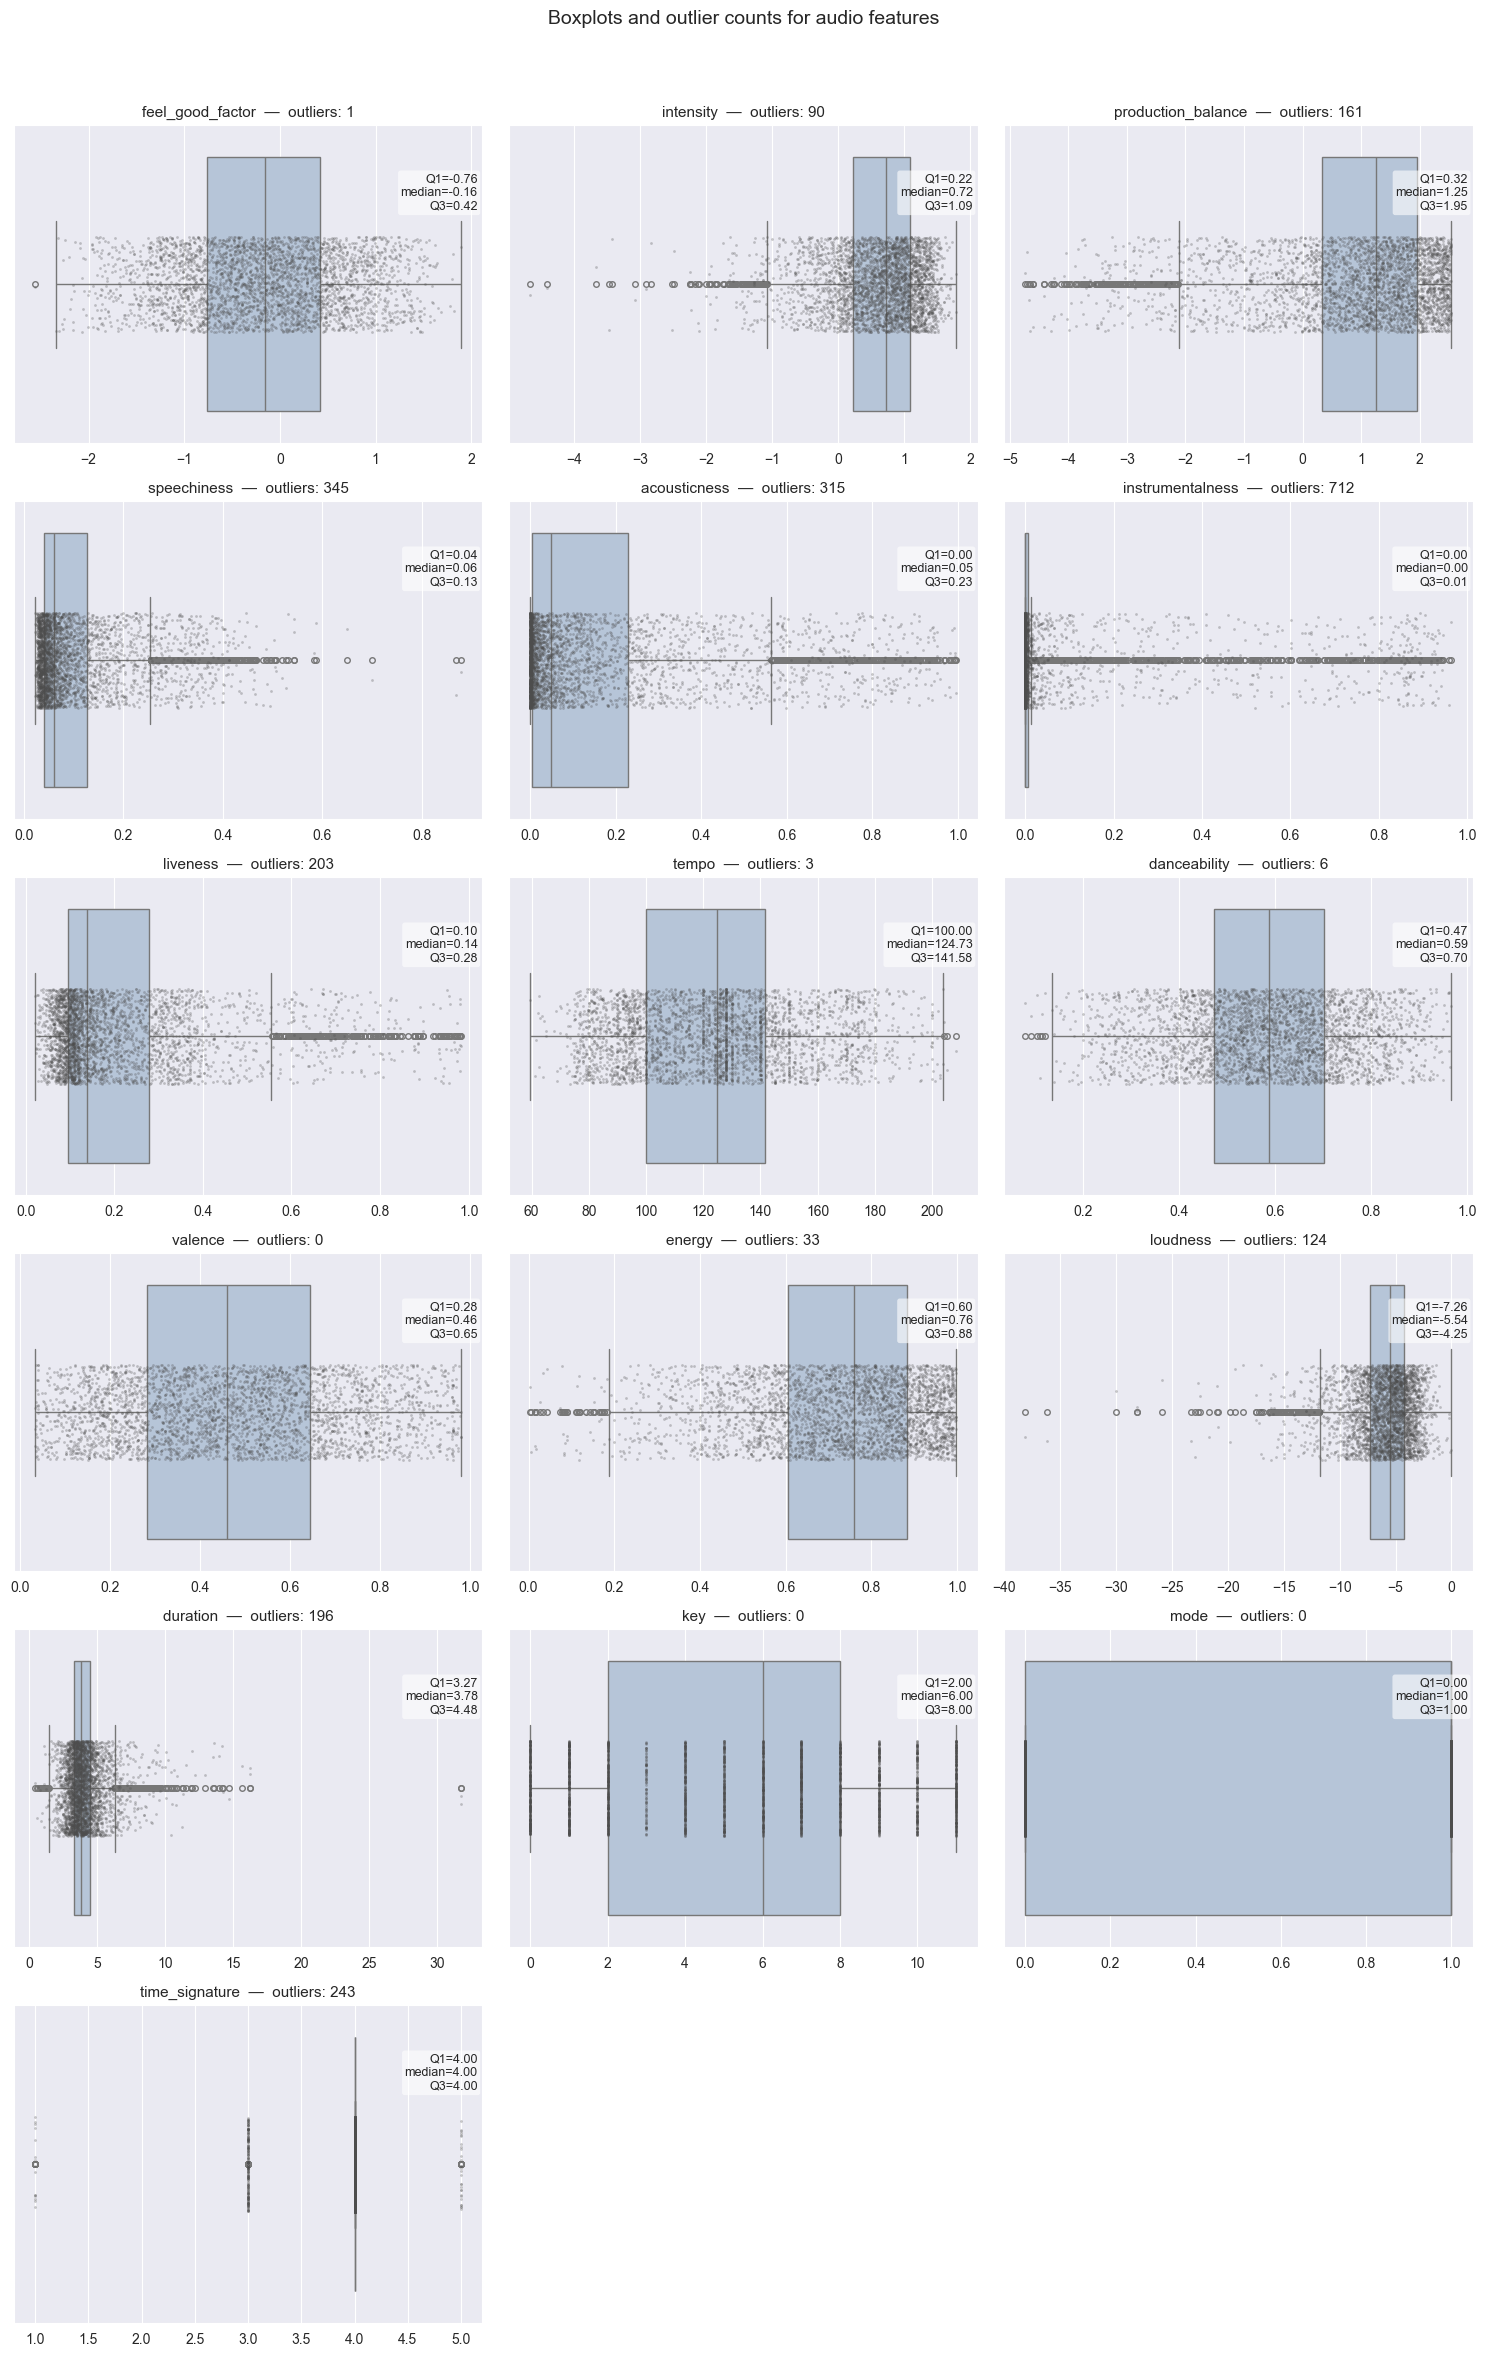

In [647]:
# python
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ensure features exist in the dataframe
features = [f for f in numerical_audio_features + categorical_audio_features if f in songs_past_20_years.columns]
if not features:
    raise ValueError("No numerical audio features found in `songs_past_20_years`.")

n_cols = 3
n_rows = math.ceil(len(features) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    data = songs_past_20_years[feat].dropna().astype(float)

    # IQR-based outlier detection
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    median = data.median()
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = data[(data < lower) | (data > upper)]
    outlier_count = len(outliers)

    # boxplot + low-alpha points for context
    sns.boxplot(x=data, ax=ax, color="lightsteelblue", orient="h", fliersize=4)
    sns.stripplot(x=data, ax=ax, color="0.3", size=2, alpha=0.3, orient="h", jitter=0.15)

    ax.set_title(f"{feat}  —  outliers: {outlier_count}", fontsize=11)
    ax.set_xlabel("")  # keep axis clean
    ax.set_yticks([])

    # annotate limits (optional)
    ax.text(0.99, 0.85, f"Q1={q1:.2f}\nmedian={median:.2f}\nQ3={q3:.2f}", transform=ax.transAxes,
            ha="right", va="top", fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.6))

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Boxplots and outlier counts for audio features", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [658]:
# python
import numpy as np
import pandas as pd

def outlier_report_with_examples(df, features, id_cols=('name', 'artist'), n_examples=6):
    """
    Return a DataFrame report with IQR stats + a compact list of example outlier rows
    (shows up to `n_examples`, balanced between low and high extremes).
    """
    report = []
    for f in features:
        if f not in df.columns:
            continue
        x = df[f].dropna().astype(float)
        n = len(x)
        if n == 0:
            continue
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        out_mask = (df[f] < lower) | (df[f] > upper)
        pct_out = float(out_mask.mean())
        p1, p99 = np.percentile(x, [1, 99])
        skew = float(x.skew())

        # Gather example rows for the outliers (include id_cols + value)
        out_rows = df.loc[out_mask & df[f].notna(), list(id_cols) + [f]].copy()
        # sort ascending so head = lowest, tail = highest
        out_rows = out_rows.sort_values(by=f)
        # split examples between low/high extremes
        n_low = min(len(out_rows), n_examples // 2)
        n_high = min(len(out_rows) - n_low, n_examples - n_low)
        examples_list = []
        if n_low > 0:
            low_examples = out_rows.head(n_low)
            examples_list += [f"{r[name_col]} — {r[artist_col]} — {r[f]:.3f}"
                              for _, r in low_examples.reset_index(drop=True).iterrows()
                              for name_col, artist_col in [id_cols]]
        if n_high > 0:
            high_examples = out_rows.tail(n_high)
            examples_list += [f"{r[name_col]} — {r[artist_col]} — {r[f]:.3f}"
                              for _, r in high_examples.reset_index(drop=True).iterrows()
                              for name_col, artist_col in [id_cols]]

        # Also include a short extremes numeric summary (first/last values)
        numeric_extremes = []
        if not x.empty:
            numeric_extremes = [float(v) for v in x.sort_values().head(3)] + [float(v) for v in x.sort_values().tail(3)]

        report.append({
            "feature": f,
            "n": n,
            "pct_outliers": pct_out,
            "iqr_lower": lower,
            "iqr_upper": upper,
            "p1": p1,
            "p99": p99,
            "skew": skew,
            "numeric_extremes": numeric_extremes,
            "examples_compact": " | ".join(examples_list) if examples_list else ""
        })

    return pd.DataFrame(report).sort_values("pct_outliers", ascending=False)

# --- Usage: produce report and print concise table ---
features = [f for f in numerical_audio_features if f in songs_past_20_years.columns]
rep = outlier_report_with_examples(songs_past_20_years, features, id_cols=('name', 'artist'), n_examples=6)
rep[["feature", "n", "pct_outliers", "skew", "p1", "p99", "examples_compact"]]

,feature,n,pct_outliers,skew,p1,p99,examples_compact
5,instrumentalness,3369,0.211339,2.966019,0.000000,0.897640,Express Yourself - Mochakk Remix — Diplo — 0.9...
3,speechiness,3369,0.102404,2.081961,0.026000,0.434960,B*tch From Da Souf — Latto — 0.699 | I'm Not R...
4,acousticness,3369,0.093500,1.726652,0.000009,0.912000,Air (Dublinesque) — Billy Joel — 0.993 | Star ...
6,liveness,3369,0.060255,1.966770,0.038212,0.885320,Wait for Me - Live — Susan Tedeschi — 0.981 | ...
12,duration,3369,0.058178,5.320533,1.810000,9.402400,Lilin — John Zorn — 16.230 | The Way Up: Openi...
2,production_balance,3369,0.047789,-1.349050,-3.527168,2.509182,Victim of Love — Charles Bradley — -2.170 | Op...
11,loudness,3369,0.036806,-2.512051,-15.636800,-1.698480,Full Metal Jackoff — D.O.A. — -11.857 | Tribes...
1,intensity,3369,0.026714,-1.457386,-1.555624,1.562012,I'll Be Alright — Eric Clapton — -1.084 | I'm ...
10,energy,3369,0.009795,-0.792796,0.190720,0.991320,A Woman Clothed With the Sun — John Zorn — 0.1...
8,danceability,3369,0.001781,-0.203866,0.197680,0.923000,Blackwater Park — Opeth — 0.109 | Through the ...


#### As we can see there are some features with a lot of outliers like duration, instrumentalness and speechiness and some with very few outliers like valence and danceability
but we will keep all the outliers for our analysis as they may represent important characteristics of songs.
the model we will use later is robust to outliers. (Random Forest Classifier)

In [646]:
songs_longer_then_10_minutes = songs_past_20_years[songs_past_20_years["duration"] > 10]
# print(f"number of songs longer than 10 minutes: {len(songs_longer_then_10_minutes)}")
display(songs_longer_then_10_minutes[["name", "artist", "duration","is_success"]])

,name,artist,duration,is_success
174,All Too Well (10 Minute Version) (Taylor's Ver...,Taylor Swift,10.22,1
1568,Green Eyes,Erykah Badu,10.08,0
1643,Ghost of Perdition,Opeth,10.49,0
1798,Ghost Love Score,Nightwish,10.03,0
1997,Lingus,Snarky Puppy,10.76,0
2138,My Testimony,Marvin Sapp,10.42,0
2150,Deliverance,Opeth,13.61,0
2163,In the Name of God,Dream Theater,14.25,0
2200,Blackwater Park,Opeth,12.19,0
2242,The Drapery Falls,Opeth,10.87,0


In [636]:
songs_per_artist = songs_past_20_years["artist"].value_counts()
mean_per_artist = songs_per_artist.mean()
median_per_artists = songs_per_artist.median()
print(f"average number of songs per artist : {mean_per_artist}")
print(f"median number of songs per artist : {median_per_artists}")

average number of songs per artist : 5.522950819672131
median number of songs per artist : 6.0


# Modelling and Analysis

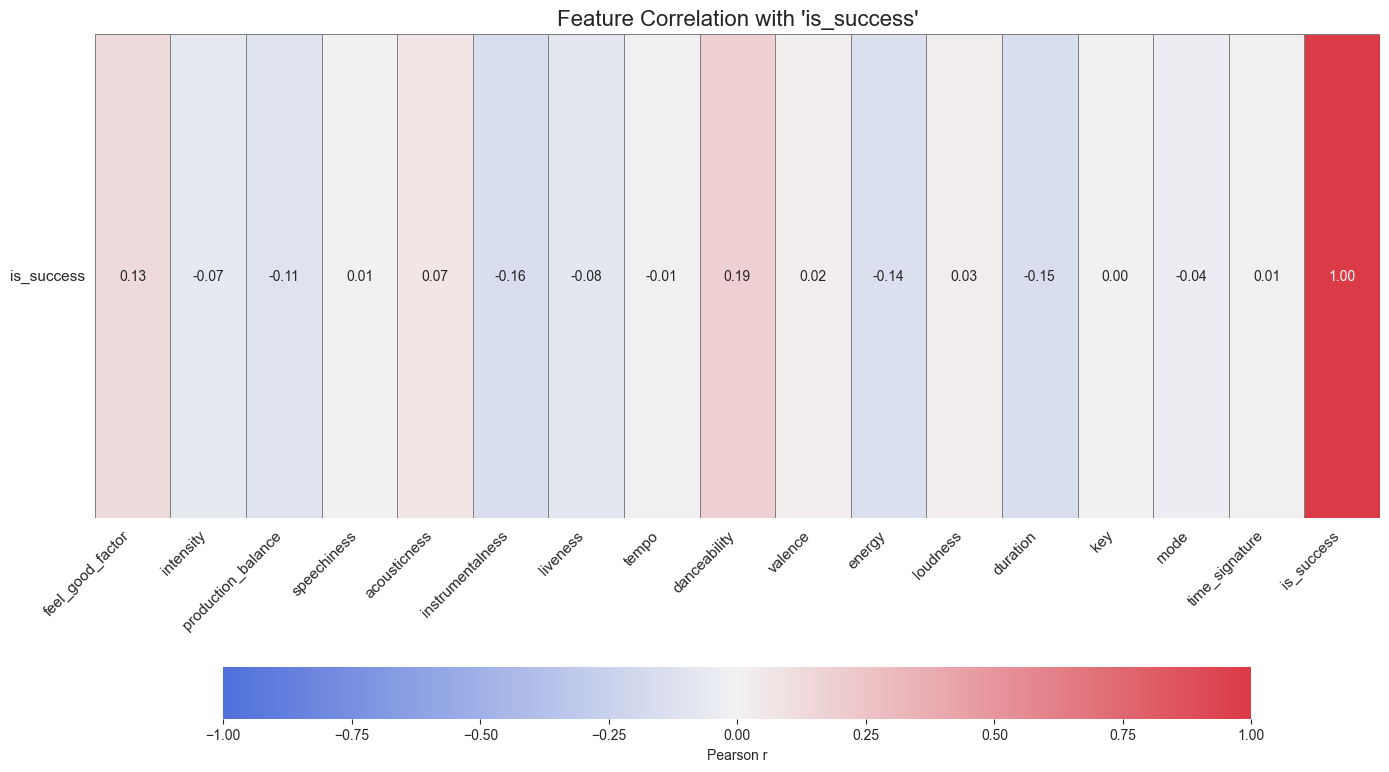

In [637]:

# --- Ensure you have a numeric success column ---
# This is a placeholder; replace 'success' with your actual numeric success column name
# and 'era' with your era column name.
SUCCESS_COL = 'is_success'

# --- Add 'mode' to the list of features for the heatmap ---
features_for_heatmap = numerical_audio_features + categorical_audio_features
cmap = sns.diverging_palette(260, 10, n=9, as_cmap=True)

df_heatmap = songs_past_20_years[features_for_heatmap + [SUCCESS_COL]]
corrs = df_heatmap.corr()

# --- Isolate the correlations with the success column and reshape for plotting ---
corrs_target = corrs[[SUCCESS_COL]].T

fig, ax = plt.subplots(figsize=(14, 8))  # Increased height for more vertical space
sns.heatmap(
    corrs_target,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    vmin=-1, vmax=1,
    center=0,
    linewidths=.5,
    linecolor='gray',
    cbar_kws={"shrink": 0.8, "label": "Pearson r", "orientation": "horizontal", "pad": 0.2},
    annot_kws={"size": 10},
    ax=ax
)
# Tidy ticks and title
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)  # Keep y-label horizontal
ax.set_title(f"Feature Correlation with '{SUCCESS_COL}'", fontsize=16)
plt.tight_layout()
plt.show()

Average Success Rate by Genre:
genre
Today        0.689145
Alt. Rock    0.523585
Rap          0.464491
R&B          0.448980
Country      0.428571
EDM          0.195489
Metal        0.181303
Funk         0.052632
Reggae       0.051546
Gospel       0.037267
Punk         0.020408
Rock         0.010309
SKA          0.009174
Jazz         0.000000
Blues        0.000000
Folk         0.000000
Disco        0.000000
World        0.000000
Name: is_success, dtype: float64


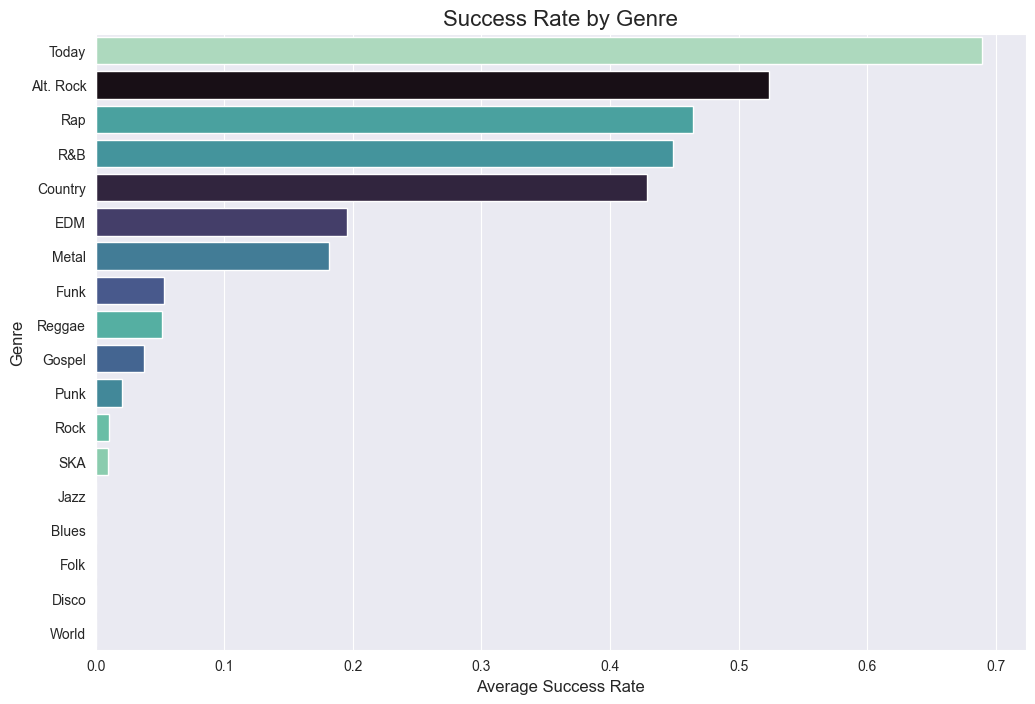

In [638]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Make sure to replace these with your actual column names ---

# Calculate the average success rate for each genre
genre_success_rate = songs_past_20_years.groupby(genre_col, observed=True)[TARGET_COL].mean().sort_values(
    ascending=False)

print("Average Success Rate by Genre:")
print(genre_success_rate)

# Plot the results
plt.figure(figsize=(12, 8))
# --- Use the 'order' parameter to ensure the plot follows the sorted data ---
sns.barplot(
    x=genre_success_rate.values,
    y=genre_success_rate.index,
    hue = genre_success_rate.index,
    legend=False,
    order=genre_success_rate.index,  # This line enforces the correct order
    palette='mako'
)
plt.title('Success Rate by Genre', fontsize=16)
plt.xlabel('Average Success Rate', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.show()

#### Random Forest Classifier that take genre into account

Preprocessing the full dataset...
Training the model with balanced class weights...

Model Out-of-Bag (OOB) Accuracy: 0.771

--- OOB Metrics with Balanced Weights (0.49 Threshold) ---
              precision    recall  f1-score   support

 Not Success       0.81      0.89      0.85      2346
     Success       0.67      0.51      0.58      1023

    accuracy                           0.77      3369
   macro avg       0.74      0.70      0.71      3369
weighted avg       0.76      0.77      0.76      3369



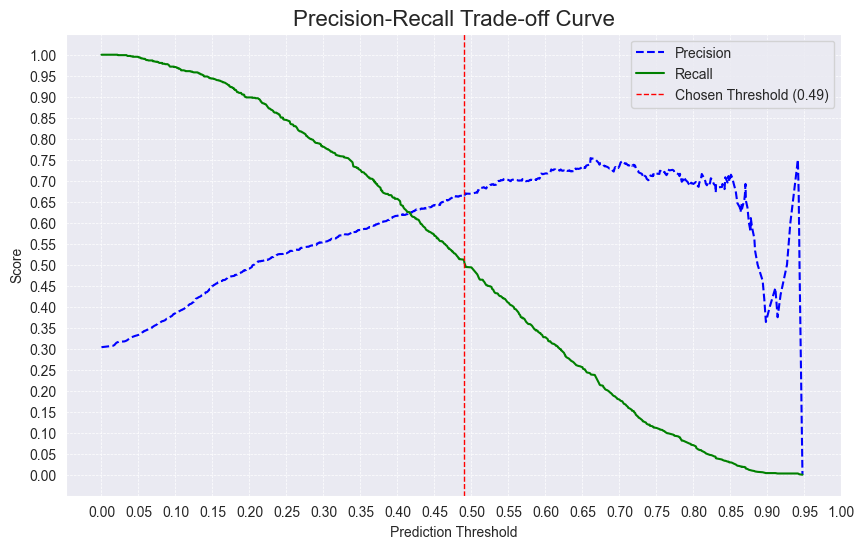

In [639]:

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt


# --- Prepare Data ---
X = songs_past_20_years[numerical_audio_features + categorical_audio_features + [genre_col]]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Preprocessing ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), numerical_audio_features),
        # --- Apply OneHotEncoder to all categorical features ---
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_audio_features + [genre_col])
    ],
    remainder='passthrough'
)
print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Train the Model with Balanced Weights ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1,
    oob_score=True,
    class_weight='balanced'  # <--- KEY CHANGE 1: Address class imbalance
)
# # Get new predictions based on our custom threshold
# y_oob_pred_high_precision = (oob_probabilities >= NEW_THRESHOLD).astype(int)
print("Training the model with balanced class weights...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

threshold = 0.49
# --- Evaluate the balanced model (at 0.53 threshold) ---
oob_probabilities = model.oob_decision_function_[:, 1]
# y_oob_pred_balanced = np.argmax(model.oob_decision_function_, axis=1)

# maek success prediction based on threshold
y_oob_pred = (oob_probabilities >= threshold).astype(int)
print(f"\n--- OOB Metrics with Balanced Weights ({threshold} Threshold) ---")
print(classification_report(y, y_oob_pred, target_names=['Not Success', 'Success']))

# --- KEY CHANGE 2: Find and Apply a Better Threshold for High Precision ---
# Get the predicted probabilities for the "Success" class from OOB

# Generate precision-recall data
precisions, recalls, thresholds = precision_recall_curve(y, oob_probabilities)

# Plot the Precision-Recall Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

# --- Add more detailed ticks and a clearer grid ---
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 1.05, 0.05))
plt.grid(which='both', linestyle='--', linewidth=0.5)

# --- Add a vertical line to show the chosen threshold ---
plt.axvline(x=threshold, color='r', linestyle='--', linewidth=1, label=f'Chosen Threshold ({threshold})')

plt.title('Precision-Recall Trade-off Curve', fontsize=16)
plt.xlabel('Prediction Threshold')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

### Model Results:
The model was trained using both the raw audio features and the one-hot encoded `genre` column. Class weights were balanced t handle the imbalanced dataset.

---

#### regular audio features + genre
##### regular audio features:
<li> danceability
<li> valence
<li> speechiness
<li> acousticness
<li> instrumentalness
<li> liveness
<li> tempo
<li> energy
<li> loudness
<li> duration
<li> mode
<li> key

*   **Model Out-of-Bag (OOB) Accuracy:** 0.780


##### OOB Metrics with Balanced Weights (Default 0.5 Threshold)

```
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.69      0.50      0.58      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.70      0.71      3421
weighted avg       0.76      0.77      0.76      3421
```
---

#### My audio features + genre
##### my audio features:
<li> intensity
<li> production_style
<li> feel_good_factor
<li> speechiness
<li> acousticness
<li> instrumentalness
<li> liveness
<li> tempo
<li> mode
<li> key

*   **Model Out-of-Bag (OOB) Accuracy:** 0.764

##### OOB Metrics with Balanced Weights (0.52 Threshold)

```
              precision    recall  f1-score   support

 Not Success       0.80      0.89      0.84      2368
     Success       0.67      0.49      0.57      1053

    accuracy                           0.77      3421
   macro avg       0.73      0.69      0.70      3421
weighted avg       0.76      0.77      0.76      3421
```
---

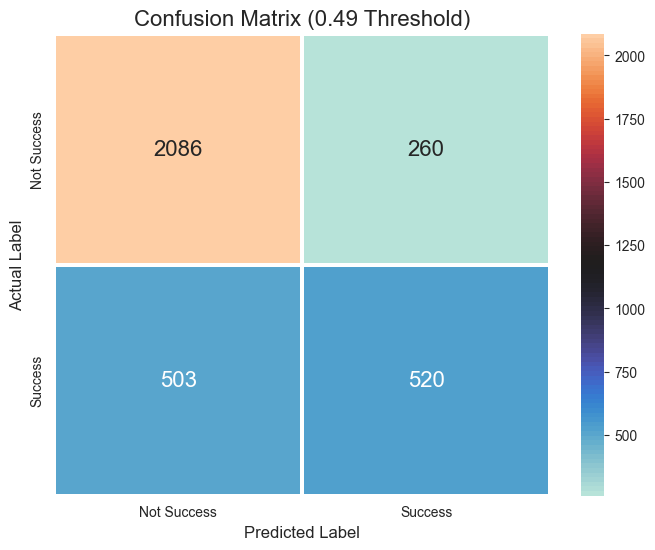

In [640]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# --- Function to plot a confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    # --- Create a custom green-to-blue color palette ---
    custom_cmap = sns.blend_palette(["#001cbe", "#008080"], as_cmap=True)  # from light green to dark blue
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=sns.color_palette("icefire", 100),
                annot_kws={"size": 16},  # Increase font size of the numbers
                linewidths=1.5,
                xticklabels=['Not Success', 'Success'],
                yticklabels=['Not Success', 'Success'])
    plt.title(title, fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()


# --- 1. Plot Confusion Matrix for the model with the default 0.5 threshold ---
plot_confusion_matrix(y, y_oob_pred, f'Confusion Matrix ({threshold} Threshold)')

#### Random Forest Classifier without Genre
used to check which audio features are most important in predicting success

In [641]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score  # Import metrics

# --- Define your columns (replace if necessary) ---
TARGET_COL = 'is_success'

# --- Prepare Data using the full dataset ---
X = songs_past_20_years[numerical_audio_features + categorical_audio_features]
y = songs_past_20_years[TARGET_COL].astype(int)

# --- Create and Fit the Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', StandardScaler(), numerical_audio_features),
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_audio_features)
    ],
    remainder='passthrough'
)

print("Preprocessing the full dataset...")
X_transformed = preprocessor.fit_transform(X)

# --- Get the Correct Feature Names After Transformation ---
# Get categorical feature names from OneHotEncoder
categorical_feature_names = preprocessor.named_transformers_['categorical'].get_feature_names_out(categorical_audio_features)
# Combine all feature names
all_feature_names = np.concatenate([numerical_audio_features, categorical_feature_names])


# --- Train the Model on the Full Dataset ---
model = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True
)

print("Training the model on the full dataset...")
model.fit(X_transformed, y)
print(f"\nModel Out-of-Bag (OOB) Accuracy: {model.oob_score_:.3f}")

# --- NEW: Calculate PPV (Precision) and other metrics from OOB predictions ---
# Get the OOB predictions for each song
y_oob_pred = np.argmax(model.oob_decision_function_, axis=1)

# Calculate Positive Predictive Value (Precision) for the "success" class (class 1)
ppv = precision_score(y, y_oob_pred, pos_label=1)

print(f"Positive Predictive Value (Precision) for 'Success': {ppv:.3f}")

# --- Find and Plot Feature Importance ---
print("\nCalculating feature importance...")
result = permutation_importance(
    model, X_transformed, y, n_repeats=10, random_state=42, n_jobs=-1
)

Preprocessing the full dataset...
Training the model on the full dataset...

Model Out-of-Bag (OOB) Accuracy: 0.699
Positive Predictive Value (Precision) for 'Success': 0.509

Calculating feature importance...


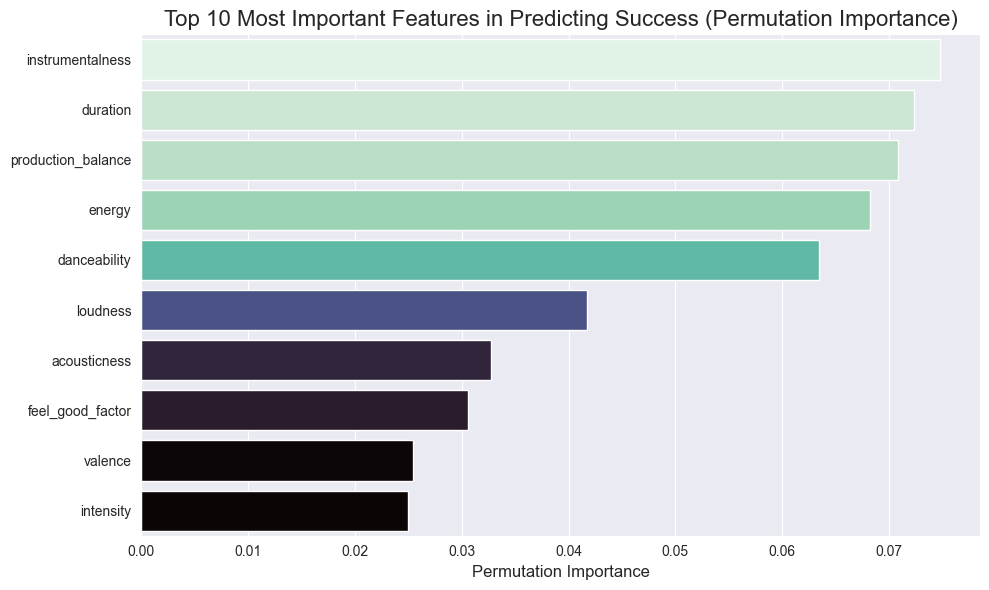


Top 10 most important features:
instrumentalness      0.074770
duration              0.072366
production_balance    0.070793
energy                0.068180
danceability          0.063402
loudness              0.041733
acousticness          0.032710
feel_good_factor      0.030632
valence               0.025408
intensity             0.024993
dtype: float64


In [642]:
importances = pd.Series(result.importances_mean, index=all_feature_names).sort_values(ascending=False)

# --- Plot the Results ---
# Take the top most important features for plotting
top_importances = importances.head(10).sort_values(ascending=False)
my_palette = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
plt.figure(figsize=(10, 6))
# --- Use seaborn.barplot for a colorful plot ---
sns.barplot(x=top_importances.values, y=top_importances.index, hue=top_importances, legend=False,
            palette='mako')
plt.title(f'Top {len(top_importances)} Most Important Features in Predicting Success (Permutation Importance)', fontsize=16)
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('')  # The feature names are the labels, so no need for a y-axis title
plt.tight_layout()
plt.show()

print(f"\nTop {len(top_importances)} most important features:")
print(top_importances)